### ASTR-324, Spring 2018, Ivezic & Juric, University of Washington
https://github.com/uw-astr-324-s18/astr-324-s18/notebooks/Week-7-Thu.ipynb


# Week 7, Thursday: "Total Least Squares" regression


##### Resources for this notebook include:
- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 8.  
 
- code taken and modified from 
[astroML figure 8.6](http://www.astroml.org/book_figures/chapter8/fig_total_least_squares.html)
 

In [1]:
%matplotlib inline
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import pymc as pymc
import seaborn as sns
from astroML.linear_model import TLS_logL
from astroML.plotting.mcmc import convert_to_stdev
from astroML.datasets import fetch_hogg2010test
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
# random seed 
np.random.seed(42)

In [2]:
# Define some convenience functions

# translate between typical slope-intercept representation,
# and the normal vector representation
def get_m_b(beta):
    b = np.dot(beta, beta) / beta[1]
    m = -beta[0] / beta[1]
    return m, b


def get_beta(m, b):
    denom = (1 + m * m)
    return np.array([-b * m / denom, b / denom])


# compute the ellipse principal axes and rotation from covariance
def get_principal(sigma_x, sigma_y, rho_xy):
    sigma_xy2 = rho_xy * sigma_x * sigma_y

    alpha = 0.5 * np.arctan2(2 * sigma_xy2,
                             (sigma_x ** 2 - sigma_y ** 2))
    tmp1 = 0.5 * (sigma_x ** 2 + sigma_y ** 2)
    tmp2 = np.sqrt(0.25 * (sigma_x ** 2 - sigma_y ** 2) ** 2 + sigma_xy2 ** 2)

    return np.sqrt(tmp1 + tmp2), np.sqrt(tmp1 - tmp2), alpha


# plot ellipses
def plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, factor=2, ax=None):
    if ax is None:
        ax = plt.gca()

    sigma1, sigma2, alpha = get_principal(sigma_x, sigma_y, rho_xy)

    for i in range(len(x)):
        ax.add_patch(Ellipse((x[i], y[i]),
                             factor * sigma1[i], factor * sigma2[i],
                             alpha[i] * 180. / np.pi,
                             fc='none', ec='k'))
        
# Find best-fit parameters
def get_best_fit(x, y, sigma_x, sigma_y, rho_xy):
    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y

    # note: TLS_logL was imported from astroML.linear_model 
    min_func = lambda beta: -TLS_logL(beta, X, dX)
    # this is optimization, not MCMC
    return optimize.fmin(min_func, x0=[-1, 1])


# plot results 
def plot_best_fit(x, y, sigma_x, sigma_y, rho_xy, beta_fit, mLSQ, bLSQ):
    fig = plt.figure(figsize=(8, 5))
    fig.subplots_adjust(left=0.1, right=0.95, wspace=0.25, bottom=0.15, top=0.9)
    ax = fig.add_subplot(121)
    ax.scatter(x, y, c='k', s=9)
    plot_ellipses(x, y, sigma_x, sigma_y, rho_xy, ax=ax)
    
    # plot the best-fit line
    m_fit, b_fit = get_m_b(beta_fit)
    x_fit = np.linspace(0, 300, 10)
    ax.plot(x_fit, m_fit * x_fit + b_fit, '-k')
    ax.plot(x_fit, mLSQ * x_fit + bLSQ, '--', c='red')

    ax.set_xlim(40, 250)
    ax.set_ylim(100, 600)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    # plot the likelihood contour in m, b
    ax = fig.add_subplot(122)
    m = np.linspace(1.7, 2.8, 100)
    b = np.linspace(-60, 110, 100)
    logL = np.zeros((len(m), len(b)))

    X = np.vstack((x, y)).T
    dX = np.zeros((len(x), 2, 2))
    dX[:, 0, 0] = sigma_x ** 2
    dX[:, 1, 1] = sigma_y ** 2
    dX[:, 0, 1] = dX[:, 1, 0] = rho_xy * sigma_x * sigma_y
    for i in range(len(m)):
        for j in range(len(b)):
            logL[i, j] = TLS_logL(get_beta(m[i], b[j]), X, dX)

    ax.contour(m, b, convert_to_stdev(logL.T),
           levels=(0.683, 0.955, 0.997), colors='k')
    ax.plot([-1000, 1000], [bLSQ, bLSQ], ':k', lw=1, c='red')
    ax.plot([mLSQ, mLSQ], [-1000, 1000], ':k', lw=1, c='red')

    ax.set_xlabel('slope')
    ax.set_ylabel('intercept')
    ax.set_xlim(1.7, 2.8)
    ax.set_ylim(-60, 110)

    plt.show()

In [3]:
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, see the lecture)
x = data['x']
y = data['y']
sigma_x = data['sigma_x']
sigma_y = data['sigma_y']
rho_xy = data['rho_xy']

In [9]:
# for comparison, let's get the standard LSQ solution
mux = np.mean(x)
muy = np.mean(y)
mLSQ = np.sum(x*y-mux*muy)/np.sum((x-mux)**2)
bLSQ = muy - mLSQ*mux
print('mLSQ=', mLSQ)
print('bLSQ=', bLSQ)

mLSQ= 2.19102799643
bLSQ= 32.003969391


Optimization terminated successfully.
         Current function value: 56.688229
         Iterations: 85
         Function evaluations: 160
m= 2.2993032767
b= 24.1515059908


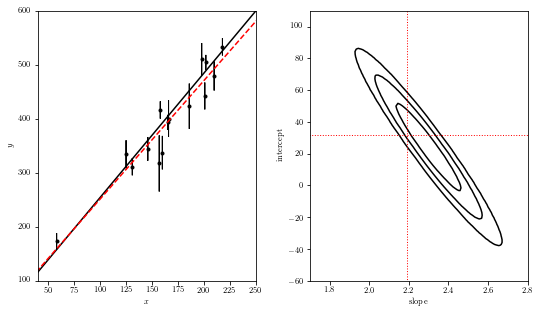

In [10]:
## let's do only errors in y - this is standard LSQ 
# Find best-fit parameters
err_x = 0*sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit1 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit1, b_fit1 = get_m_b(best_fit1)
print('m=', m_fit1)
print('b=', b_fit1)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit1, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 72.220549
         Iterations: 171
         Function evaluations: 318
m= 2.59610711754
b= -43.9768263127


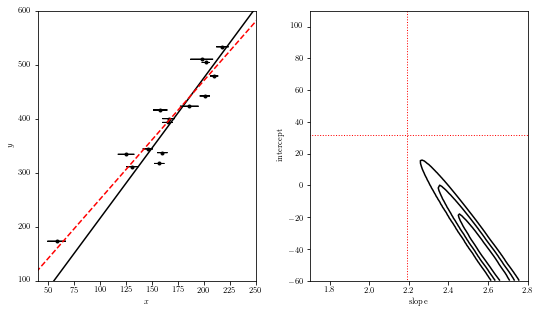

In [11]:
## now only errors in x; note that we could switch the axes and use standard LSQ
# Find best-fit parameters
err_x = sigma_x
err_y = 0*sigma_y
rho = rho_xy
best_fit2 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit2, b_fit2 = get_m_b(best_fit2)
print('m=', m_fit2)
print('b=', b_fit2)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit2, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 56.630031
         Iterations: 71
         Function evaluations: 136
m= 2.38493448804
b= 6.04223400707


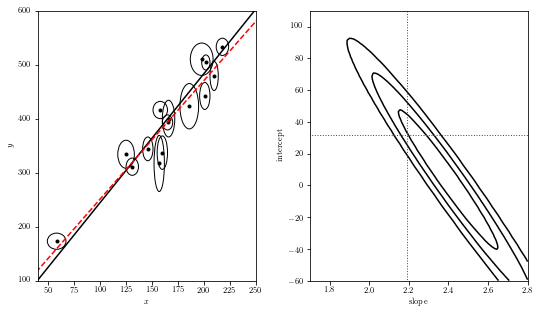

In [12]:
## errors in x and y, but without covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = 0*rho_xy
best_fit3 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit3, b_fit3 = get_m_b(best_fit3)
print('m=', m_fit3)
print('b=', b_fit3)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit3, mLSQ, bLSQ)

Optimization terminated successfully.
         Current function value: 55.711167
         Iterations: 88
         Function evaluations: 164
m= 2.24878537523
b= 27.9304349421


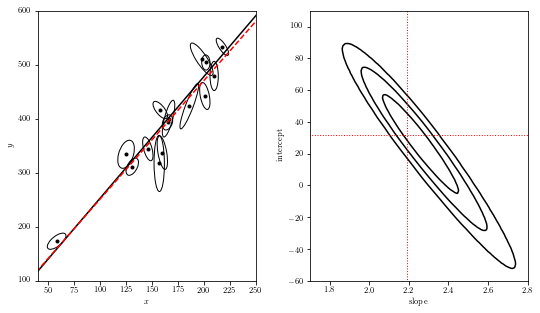

In [13]:
## errors in x and y with covariance
# Find best-fit parameters
err_x = sigma_x
err_y = sigma_y
rho = rho_xy
best_fit4 = get_best_fit(x, y, err_x, err_y, rho) 
m_fit4, b_fit4 = get_m_b(best_fit4)
print('m=', m_fit4)
print('b=', b_fit4)
# plot best fit 
plot_best_fit(x, y, err_x, err_y, rho, best_fit4, mLSQ, bLSQ)

In [15]:
# compare all 4 versions and LSQ
print('m=', m_fit1, m_fit2, m_fit3, m_fit4, mLSQ)

m= 2.2993032767 2.59610711754 2.38493448804 2.24878537523 2.19102799643


##### MCMC-based more general method

Let's know first solve the same straight line fitting problem using MCMC
and then we will solve another non-linear problem

In [16]:
# We'll use the data from table 1 of Hogg et al. 2010
data = fetch_hogg2010test()
data = data[5:]  # no outliers (the first 5 points are outliers, see the lecture)
x_obs = data['x']
y_obs = data['y']
x_error = data['sigma_x']
y_error = data['sigma_y']

In [17]:
def doMCMC(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        b = pymc.Uniform('b', -100, 100, value= 0.0)
        m = pymc.Uniform('m', -1000, 1000, value= 1.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def straightLine(x=xLatent, b=b, m=m):
            return m*x + b
    
        y = pymc.Normal('y', mu=straightLine, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['b', 'm']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.b.value, M.m.value)
    return traces, fit_vals

In [18]:
# run MCMC for the straight line fit
traces, fit_vals = doMCMC(x_obs, y_obs, x_error, y_error, True, 200000, 20000)

 [-----------------100%-----------------] 200000 of 200000 complete in 25.8 sec

In [19]:
print("BASIC STATS:")
print('b:', np.mean(traces[0]), np.median(traces[0]), np.std(traces[0]))
print('m:', np.mean(traces[1]), np.median(traces[1]), np.std(traces[1]))
print('old (fast) results for b and m:', b_fit3, m_fit3)

BASIC STATS:
b: 28.3110907409 29.2658323357 27.3888514639
m: 2.25323088718 2.24669674073 0.156934336264
old (fast) results for b and m: 6.04223400707 2.38493448804


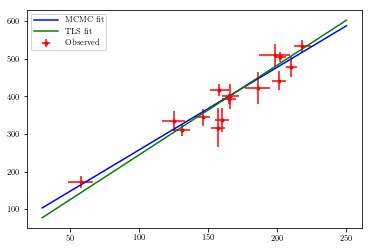

In [20]:
# extract and plot results
x_fit = np.linspace(30,250,220)
yfitMCMC = fit_vals[0] + fit_vals[1] * x_fit
yfitTLS = b_fit3 + m_fit3 * x_fit
plt.errorbar(x_obs,y_obs,xerr=x_error, yerr=y_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,yfitMCMC,'-', c='blue', label='MCMC fit')
plt.plot(x_fit,yfitTLS,'-', c='green', label='TLS fit')
plt.legend()
plt.show()

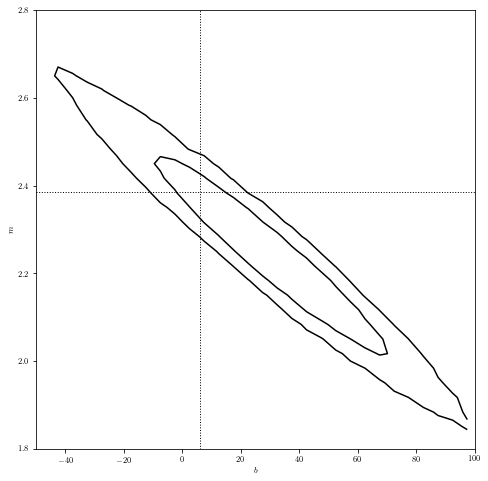

In [21]:
###  look at the posterior pdf p(b,m) from MCMC 
# a helper routine for more informative plots
from astroML.plotting.mcmc import plot_mcmc

labels = ['$b$', '$m$']
limits = [(-50, 100), (1.8, 2.8)]
TLS = [b_fit3, m_fit3]
 
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.1, top=0.95, left=0.1, right=0.95,
                    hspace=0.05, wspace=0.05)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=TLS, fig=fig,
          bins=30, colors='k')

plt.show()

In [22]:
### now let's redo the above code to be able to do a parabola
### y = a + b*x + c*x^2 
### (an analogous modification will be needed for Homework #8)
def doMCMCparabola(xObs, yObs, xErr, yErr, doXerror = False, nChain = 10000, nBurn = 2000): 
    def model(xObs, yObs, xErr, yErr, doXerror): 
        a = pymc.Uniform('a', -1000, 1000, value= 1.0)
        b = pymc.Uniform('b', -1000, 1000, value= 0.0)
        c = pymc.Uniform('c', -1000, 1000, value= 0.0)

        if (doXerror):
            xLatent = pymc.Normal('x', mu=xObs, tau=(xErr)**-2)  
        else:
            xLatent = xObs 
        
        @pymc.deterministic()
        def parabola(x=xLatent, a=a, b=b, c=c):
            return a + b*x + c*x*x
    
        y = pymc.Normal('y', mu=parabola, tau=(yErr)**-2, value=yObs, observed=True)
        return locals()

    myModel = pymc.MCMC(model(xObs,yObs, xErr, yErr, doXerror))
    myModel.sample(nChain, nBurn, 1)
    traces = [myModel.trace(s)[:] for s in ['a', 'b', 'c']]
    M = pymc.MAP(myModel)
    M.fit()
    fit_vals = (M.a.value, M.b.value, M.c.value)
    return traces, fit_vals

In [23]:
# run MCMC for the parabola fit
traces, fit_vals = doMCMCparabola(x_obs, y_obs, x_error, y_error, True, 200000, 20000)

 [-----------------100%-----------------] 200000 of 200000 complete in 33.3 sec

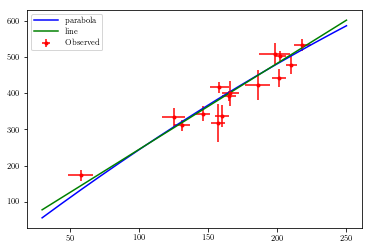

In [24]:
# extract and plot results
x_fit = np.linspace(30,250,220)
yfitParabola = fit_vals[0] + fit_vals[1] * x_fit + fit_vals[2] * x_fit*x_fit
yfitLine = b_fit3 + m_fit3 * x_fit
plt.errorbar(x_obs,y_obs,xerr=x_error, yerr=y_error, color='r', marker='.', ls='None', label='Observed')
plt.plot(x_fit,yfitParabola,'-', c='blue', label='parabola')
plt.plot(x_fit,yfitLine,'-', c='green', label='line')
plt.legend()
plt.show()

In [29]:
print("BASIC STATS:")
print( 'a:', np.mean(traces[0]), np.median(traces[0]), np.std(traces[0]))
print( 'b:', np.mean(traces[1]), np.median(traces[1]), np.std(traces[1]))
print( 'c:', np.mean(traces[2]), np.median(traces[2]), np.std(traces[2]))

BASIC STATS:
a: 79.3509667506 82.8575830666 54.00963688
b: 1.44215961523 1.42176666545 0.764487085045
c: 0.00283795704464 0.002838425895 0.00261020687648


In [ ]:
labels = ['$a$', '$b$', '$c$']
limits = [(-250, 300), (-0.5, 3.8), (-0.01, 0.01)]
TLS = [b_fit3, m_fit3, 0.0]
 
fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(bottom=0.3, top=0.8, left=0.15, right=0.9,
                    hspace=0.15, wspace=0.15)

# This function plots multiple panels with the traces
plot_mcmc(traces, labels=labels, limits=limits, true_values=TLS, fig=fig,
          bins=30, colors='k')

plt.show()

## Linear Basis Function Regression 


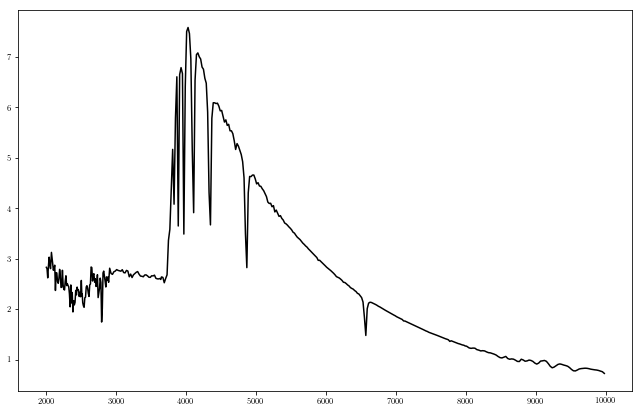

In [27]:
from astroML.datasets import fetch_vega_spectrum
# Fetch the data
x, y = fetch_vega_spectrum()
# truncate the spectrum
mask = (x >= 2000) & (x < 10000)
x = x[mask]
y = y[mask]*1.0e14

# a quick plot 
plt.figure(figsize=(11, 7))
plt.plot(x, y, '-k', label='input spectrum')
plt.show()

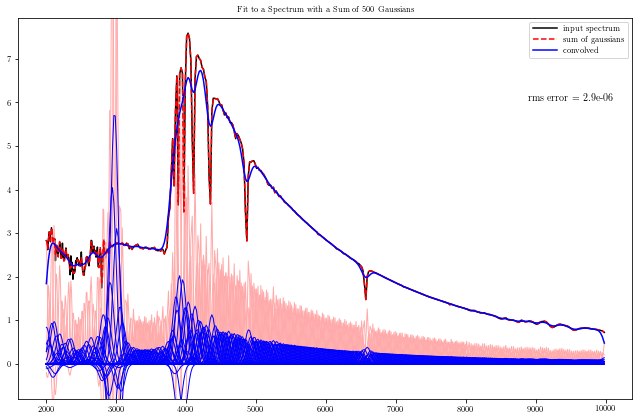

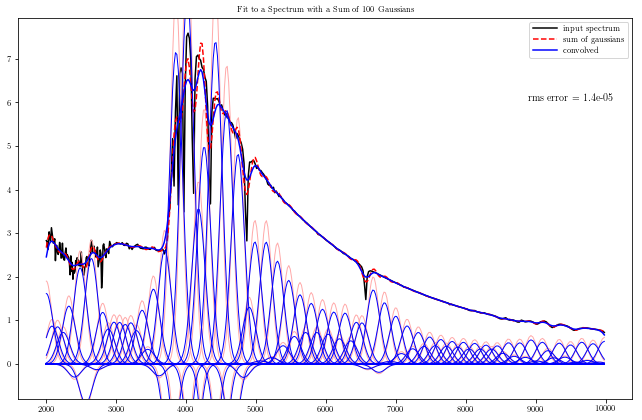

In [28]:
from astroML.sum_of_norms import sum_of_norms, norm
for n_gaussians in (500, 100):
    # compute the best-fit linear combination
    w_best, rms, locs, widths = sum_of_norms(x, y, n_gaussians,
                                             spacing='linear',
                                             full_output=True)

    norms = w_best * norm(x[:, None], locs, widths)
    # convolve with a gaussian instrumental resolution 
    widths2 = np.sqrt(widths**2 + 50**2)
    norms2 = w_best * norm(x[:, None], locs, widths2)


    # plot the results
    plt.figure(figsize=(11, 7))
    plt.plot(x, y, '-k', label='input spectrum')
    ylim = plt.ylim()

    plt.plot(x, norms, ls='-', c='#FFAAAA', lw=1)
    plt.plot(x, norms.sum(1), '--r', label='sum of gaussians')

    plt.plot(x, norms2, ls='-', c='blue', lw=1)
    plt.plot(x, norms2.sum(1), '-b', label='convolved')

    plt.ylim(-0.1 * ylim[1], ylim[1])
    plt.legend(loc=0)
    plt.text(0.97, 0.8,
             "rms error = %.2g" % rms,
             ha='right', va='top', transform=plt.gca().transAxes)
    plt.title("Fit to a Spectrum with a Sum of %i Gaussians" % n_gaussians)

plt.show()
